# Interconnected Graph Builder

Here you can find all processes of building our dataset - graph of Innopolis city. All coordinates of city buildings were collected manualy with use of 'Yandex Maps'. Now all we need to complete our dataset is to build graph.

In [29]:
import os
import json
from geopy.distance import geodesic
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt

Some functions for retriving and saving data

In [30]:
def get_data(path: str) -> list:
    """ Extracts nodes and graph information from given json file

    Args:
        path (str): Path to file

    Returns:
        List of nodes with its names, ids, and coords
    """
    PATH = os.path.abspath(path)

    with open(PATH, 'r') as file:
        data = json.load(file)
        nodes = data['nodes']

        return nodes

In [31]:
def save_data(path: str, nodes: list, graph: list) -> None:
    """ Saves nodes and graph to json file

    Args:
        path (str): Path to json
        nodes (list): List of nodes
        graph (list): 2D array of distances
    """
    PATH = os.path.abspath(path)

    data = {
        'nodes': nodes,
        'graph': graph
    }

    with open(PATH, 'w') as file:
        json.dump(data, file)

Additionally we add functionality to plot graphs

In [32]:
def plot_graph(nodes: list, paths:list = None) -> None:
    """ Plots graph and paths if needed

    Args:
        nodes (list): List of nodes
        paths (list): List of paths 
    """
    
    df = pd.DataFrame(nodes)

    fig = px.scatter_map(df,
                        lat="atd",
                        lon="lng",
                        hover_name="name",
                        color="id",
                        color_continuous_scale=px.colors.sequential.Viridis,
                        zoom=14,
                        height=800,
                        width=800)
    
    if paths is not None:
        coord_map = {row['id']: (row['atd'], row['lng']) for _, row in df.iterrows()}
        
        path_colors = px.colors.qualitative.Plotly
        
        for i, path in enumerate(paths):
            lats, lons = [], []
            for node_id in path:
                lat, lon = coord_map[node_id]
                lats.append(lat)
                lons.append(lon)
            
            fig.add_trace(go.Scattermap(
                mode="lines+markers",
                lon=lons,
                lat=lats,
                line=dict(width=3, color=path_colors[i % len(path_colors)]),
                name=f"Path {i+1}",
                marker=dict(size=8, color=path_colors[i % len(path_colors)]),
                hoverinfo="none"
            ))

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                    coloraxis_showscale=False)
    fig.show()

To convert longitude and attitude to distances in graph **geopy** library were used 

In [33]:
def get_distances(nodes: list) -> list:
    """ Generates 2D array of distances

    Args:
        nodes (list): List of nodes

    Returns:
        list: 2D array of distances
    """
    graph = [[0 for _ in range(len(nodes))] for __ in range(len(nodes))]

    for node1 in nodes[:20]:
        for node2 in nodes[:20]:
            if node1['id'] == node2['id']:
                continue

            cord1 = (node1['atd'], node1['lng'])
            cord2 = (node2['atd'], node2['lng'])

            graph[node1['id']][node2['id']] = geodesic(cord1, cord2).m
            graph[node2['id']][node1['id']]  = graph[node1['id']][node2['id']] 

    return graph

Now we can convert coordinates to distances and save them in **graph.json** file

In [34]:
nodes = get_data('../data/nodes.json')
graph = get_distances(nodes)
save_data('../data/graph.json', nodes, graph)

Now we can plot our graph and try to plot some paths

In [35]:
paths = [[1, 2, 3, 4],
         [12, 10, 5, 6],
         [31, 32, 33],
         [22, 21]]

plot_graph(nodes, paths)

In [36]:
df = pd.read_csv('../results_dp.csv')
df

,Graph Size,Execution Time (s),Iterations,Memory (bytes),Shortest Path,Path Length (m)
0,2,0.000051,2,384,0 -> 1 -> 0,1099.85
1,3,0.000031,5,432,0 -> 1 -> 2 -> 0,1153.74
2,4,0.000046,16,768,0 -> 1 -> 2 -> 3 -> 0,1218.56
3,5,0.000115,53,2872,0 -> 1 -> 2 -> 3 -> 4 -> 0,1289.25
4,6,0.000252,166,5600,0 -> 4 -> 3 -> 2 -> 1 -> 5 -> 0,1466.98
5,7,0.001348,487,25000,0 -> 1 -> 2 -> 3 -> 4 -> 6 -> 5 -> 0,1499.68
6,8,0.002751,1352,52248,0 -> 1 -> 2 -> 3 -> 4 -> 6 -> 5 -> 7 -> 0,1505.82
7,9,0.013386,3593,138112,0 -> 7 -> 5 -> 6 -> 4 -> 3 -> 2 -> 1 -> 8 -> 0,1505.90
8,10,0.041122,9226,320880,0 -> 7 -> 5 -> 6 -> 4 -> 3 -> 2 -> 1 -> 9 -> 8...,1521.58
9,11,0.107179,23051,739032,0 -> 8 -> 9 -> 1 -> 2 -> 3 -> 4 -> 6 -> 5 -> 7...,1523.57


In [37]:
df['Shortest Path'] = df['Shortest Path'].apply(lambda x: [int(node) for node in x.split(' -> ')])


In [38]:
# Extract all paths from df['Shortest Path']
all_paths = df['Shortest Path'].tolist()

# Plot all paths on a single map
plot_graph(nodes, all_paths)


21: 5427.203537
22: 13888.985868
23: 35543.890536
24: 90961.871977
25: 232784.369657
26: 595728.315380
27: 1524553.501029
28: 3901549.275893
29: 9984619.589894
30: 25552061.836280
31: 65391361.003466
32: 167345794.687080
33: 428261693.436322
34: 1095982593.455076


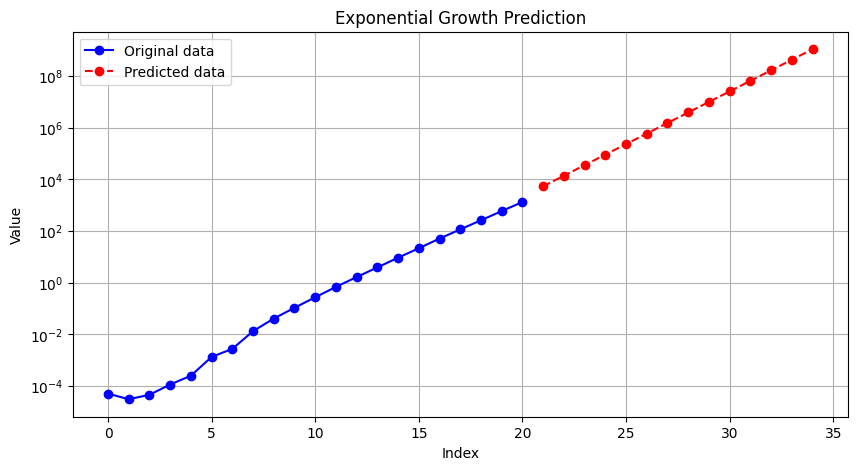